In [1]:
def windows(sample_data, window_size):
    start = 0
    while start < sample_data.shape[1]:
        yield start, start + window_size
        start += (window_size)
        
def ts_to_supervise(data,window_size,n_var):
    """
        Convert input data into LSTMs data
        
        args:
        window_size : the length of time-series. All input columns must have identical length
        n_var : number of features regardless the time-series period
        
        returns:
        result_array : A 3-D LSTMs array 
        
    """
    import numpy as np

    result_array = np.asarray(np.zeros((data.shape[0],window_size,n_var)))
    for i in range(0,data.shape[0]):
    
        segments = None
        
        for (start, end) in windows(data, window_size):
            if (data[:,start:end].shape[1]== (window_size)):
                signal = np.asarray(data[i,start:end])
                if segments is None:
                    segments = signal
                else:
                    segments = np.vstack([segments, signal])
        segments = segments.transpose()

        result_array[i,:,:] = segments
    return(result_array)

def drop_col(columns, col_thresh, sample_x):
    """
        Drop zero-inflation columns
    """
    col_to_drop = []
    zero_probs = []
    
    for col in columns:
        
        zero_prob = sum((sample_x[col] == 0).astype(int))/len(sample_x[col])
        
        zero_probs.append(zero_prob)
        
        if sample_x[col].dtype != 'int64':
            sample_x[col].astype('int64')
            print("[features]: numerize colname names:" ,col)  
        
        if zero_prob > col_thresh:
            col_to_drop.append(col)
            print('[features]:',col, "has been dropped with zeros more than", zero_prob)
    return col_to_drop, zero_probs

def get_feature_name(col_list):
    """
        Get the time-series features' names regardless of the time period
    """
    feature_names =[]
    for col in col_list:
        feature_name = col.split('_')[0]
        feature_names.append(feature_name)
    return(feature_names)

def features_extract (sample_df, ts_len):
    """
        Filter time-series features from the input data and return a list of those features' names
    """
    raw_features = sample_df.columns
    fea_list = get_feature_name(raw_features)

    ts_features = []
    for col in set(fea_list):
        if fea_list.count(col) == ts_len:
            ts_features.append(col)
    print('[features]: ',len(ts_features),"time series features founded from data...")

    output_features = []
    for feature_name in ts_features:
        try:
            print('[features]: generating windowed average deltas...',feature_name)
            # get the column names
            feats = list(sample_df.filter(regex=(feature_name+'*_[0-59]')).columns)
            print(len(feats),"founded")
        except:
             print('[features]: Oops! features name not found...')
        output_features.append(feats)
    output_features = [item for sublist in output_features for item in sublist]
    output_features = list(set(output_features))
    return(output_features)


def train_test_split(sample_data, valsize = 0.05, random_state = 42):
    
    import pandas as pd
    from sklearn.model_selection import train_test_split

    _, _, train_idx, val_idx = train_test_split(sample_data, sample_data.index, test_size=valsize, random_state=random_state)
    
    sample_data.ix[train_idx,'split'] = 'Train'
    sample_data.ix[val_idx,'split'] = 'Validation'
    
    print(sample_data['split'].value_counts())
    
    return(sample_data)

def plot_confusion_matrix(truth, predicted, labels={}, save_name='',
                          title='Confusion Matrix', norm=1, suppress_values=False,
                          diagonal_values=False,
                          font_size=10,
                          cmin=0,cmax=1,
                          cut_off = 1
                          ):
    # make confusion matrix from truth and predicted for classes
    # define the confusion matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import numpy as np
    
    conf_mat = confusion_matrix(truth,predicted,labels = labels)
    
    #normalise
    if norm:
        conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(9,9))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    cb = fig.colorbar(res)
    
    res.set_clim(cmin, cmax)
    
    # add number overlay
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if (not suppress_values or (diagonal_values and i==j)) and c>0 :
                cent = .1
                if diagonal_values:
                    cent = .3
                
                if norm:
                    d = round(c,2)
                    plt.text(j-cent, i+.0, d, fontsize=font_size)
                else:
                    plt.text(j-cent, i+.0, c, fontsize=font_size)
    
            if (i==j) and c > cut_off:
                cent= 0.3
                plt.text(j-cent, i+.0, 'X', fontsize=font_size)

    # set axes
    plt.xticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
    plt.yticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
    
    plt.xlabel('Predicted',fontsize=font_size+4)
    plt.ylabel('Truth',fontsize=font_size+4)
    plt.title(title,fontsize=font_size+5)

    if save_name != '':
        plt.savefig(save_name)
    plt.show()

    
def plot_roc(test_y, pred_y, roc_save_name = None):
    
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    import matplotlib.pyplot as plt
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(test_y, pred_y[:,1])
    roc_auc = auc(fpr, tpr)
    
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    if roc_save_name != '':
        plt.savefig(roc_save_name)
    plt.show()

In [33]:
def data_processing(data, label, columns, ts_len, col_thresh, random):
    """
        Pre-process the data to LSTMs data
        In this function, we clean the input dataset with selected columns, delete those zero-inflation columns
        and convert the reserved to LSTMs dataset for LSTM model fitting.
        
        args:
            data : directory of input data
            label : name of the column containing respond variable
            columns : names of the column of features (must be time series type)
            col_thresh : a threshhold value between 0 - 1 for dropping zero-inflation columns
            ts_len : length of time series
            test : True/False, testing data
            
        returns:
            feature_names_reserve: Features names reserved
            feature_names_drop: Features names dropped
            train_array: Processed training X
            val_array: Processed validation X
            test_array: Processed testing X
            Y_train: Processed training Y
            Y_val: Processed validation Y
            Y_test: Processed testing Y
            zero_probs: An array of precentage of zeros each columns
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    
    # Read data
    sample_data = pd.read_csv(data)
    
    # Extract outcome label
    sample_y = sample_data[label]

    # Extract data with interested features
    sample_x = sample_data[columns]
    
    # Obtain columns with a lot of zero values, col_thresh is the threshold for zero percentage
    
    col_to_drop, zero_probs = drop_col(columns, col_thresh, sample_x)
     
    sample_x = sample_x.drop(col_to_drop,1)
    
    # Obtain dropped feature names
    col_list = list(col_to_drop)
    feature_names_drop = get_feature_name(col_list)     
    print('[features]:',len(set(feature_names_drop)),"zero-inflation features")

    # Obtain reserved feature names
    col_list = list(sample_x.columns)
    feature_names_reserve = get_feature_name(col_list)
    print('[features]:',len(set(feature_names_reserve)),"features will be included in LSTMs model")
    
    x_values = sample_x.values
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     values = scaler.fit_transform(x_values)
#     x_values = scaler.transform(values)
    
    # Train/test split
    sample_data = train_test_split(sample_data, valsize = 0.05, random_state = random)

    # Obtain training data  
    X_train = x_values[sample_data.split=='Train']
    Y_train = np.asarray(pd.get_dummies(sample_y[sample_data.split=='Train'] ), dtype=np.int8)
    # convert training data to LSTM data
    train_array = ts_to_supervise(X_train,ts_len,len(set(feature_names_reserve)))
    
    # Obtain validation data    
    X_val = x_values[sample_data.split=='Validation']
    Y_val = np.asarray(pd.get_dummies(sample_y[sample_data.split=='Validation'] ), dtype=np.int8) 
    val_array = ts_to_supervise(X_val,ts_len,len(set(feature_names_reserve)))
    
    full_x_array = ts_to_supervise(x_values,ts_len,len(set(feature_names_reserve)))
    
    return full_x_array, feature_names_reserve, feature_names_drop, train_array, val_array, Y_train, Y_val, zero_probs

def fit_lstm(train_x, train_y, val_x, val_y, epochs, batch_size):
    """
        Fit LSTMs model
        In this function, we fit the LSTMs model with customized parameters
        args:
            train_x : training features
            train_y : training y
            val_x : validation features
            val_y : validation y
            epochs : number of epoch
            batch_size : batch size
        returns:
            lstm_model : fitted LSTM model
    """
    from keras.layers import Dense
    from keras.layers import LSTM, Dropout
    from keras import optimizers
    from keras.models import Sequential
    
    # Initialize model    
    model = Sequential()
    model.add(LSTM(128,input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False))

    model.add(Dense(2, activation='softmax'))
    opt = optimizers.adam(lr = 0.001)
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    model.summary()
    
    # 128 is the number of hidden units sent forward to the next time step, a.k.a, dimensionality of the output space.
    # input_shape is the dimensionality of the input needed to claim in the first layer.
    # return sequences is a boolean indicating whether to return the last output in the output sequence, or the full sequence.
#     model.add(LSTM(20, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True))
#     model.add(LSTM(10, return_sequences=True))
#     model.add(LSTM(5, return_sequences=False))

    # regular densely-connected NN layer with 2 dimensionality of output space.
#     model.add(Dense(2, activation='softmax'))
    
    # configure the model for training
    # loss is a loss function used in model fitting, we use categorical_crossentropy because we are predicting categorical outcome
    # optimizer is determined for compiping a Keras model
    # matrics is for evaluation matrics and here we use 'accuracy'
#     opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    # summarize the model in table
#     model.summary()
    
    # fit model
    lstm_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data= (val_x, val_y), verbose=2
                           , shuffle=False)
    
    return(lstm_model)
def val_lstm(sample_df, model, x_values, y_values, batch_size, cutoff = 0.5, roc_save_name='', cm_save_name = '', result_csv_save_name = ''):
    """
        Validate LSTMs model
        In this function, we validate our fitted LSTMs model with some evaluation plots
        args:
            model : fitted LSTMs model
            test_x : testing features
            test_y : testing y
            batch_size : batch size
            cutoff : predicted y = 1, if Predicted probability > 0.5, else, 0 
            roc_save_name : name of saved roc plot
            cm_save_name : name of saved confusion matrix plot
            result_csv_save_name : name of saved result csv file
        returns:
            result_df : result csv with predicted probability, category, etc.
    """
   
    # get fitted y
    pred_y = model.predict(x_values, batch_size=batch_size, verbose=2)
    
    
    # Combine data
    result_df = pd.concat([sample_df['serial'],sample_df['split'],pd.Series(y_values, name = 'true_y'),pd.Series(pred_y[:,1], name = 'pred_y')],axis = 1)
    
    # Write csv
    result_df.to_csv(result_csv_save_name, sep = '\t')
    
    # draw roc
    plot_roc(y_values, pred_y, roc_save_name = roc_save_name)
    
    # draw confusion matrix
    ypred = [[ 1 if x > cutoff else 0 ]for x in pred_y[:,1]]
    plot_confusion_matrix(truth = y_values, predicted = ypred,labels=[0,1],save_name=cm_save_name)
    
    return result_df

# Functions testing

In [2]:
# Noticed that the input features name in data_processing function must be exactly the same as the column name in data.
# i.e. "MaxExternalPressure_00", "MaxExternalPressure_01", ... "MaxExternalPressure_59", etc..
# Here we manually extract the interested features name ('x_name' below) before running the function.
import pandas as pd
sample_df = pd.read_csv("wide_table_val.csv")
features_list = features_extract(sample_df, 60)

[features]:  44 time series features founded from data...
[features]: generating windowed average deltas... MinPumpPerfLevel
60 founded
[features]: generating windowed average deltas... dPMin
60 founded
[features]: generating windowed average deltas... HeparinConcentration
60 founded
[features]: generating windowed average deltas... MeanMotorSpeed
60 founded
[features]: generating windowed average deltas... MaxPurgePressure
60 founded
[features]: generating windowed average deltas... MeanTargetPumpPerfLvl
60 founded
[features]: generating windowed average deltas... dPRange
60 founded
[features]: generating windowed average deltas... RangePlacement
60 founded
[features]: generating windowed average deltas... TargetPumpFlow
240 founded
[features]: generating windowed average deltas... MinMotorSpeed
60 founded
[features]: generating windowed average deltas... MaxTargetPumpFlow
60 founded
[features]: generating windowed average deltas... PumpPosition
60 founded
[features]: generating windo

In [35]:
# Feature processing
full_array_x, feature_names_reserve, feature_names_drop, X_train, X_val, Y_train, Y_val, zero_per = data_processing(data = 'wide_table_val.csv', label = 'y', columns = features_list, ts_len = 60, col_thresh = 0.5, random = 5)

MaxTargetPumpFlow_26 has been dropped with zeros more than 0.9861111111111112
numerize colname names: dPMean_22
MeanTargetPumpFlow_03 has been dropped with zeros more than 0.985663082437276
TargetPumpFlow_34 has been dropped with zeros more than 0.839605734767025
numerize colname names: dPMean_57
MinTargetPumpFlow_32 has been dropped with zeros more than 0.9864097968936678
MinTargetPumpFlow_37 has been dropped with zeros more than 0.9859617682198327
MeanTargetPumpFlow_40 has been dropped with zeros more than 0.9855137395459976
MaxTargetPumpFlow_12 has been dropped with zeros more than 0.9858124253285544
MaxTargetPumpFlow_28 has been dropped with zeros more than 0.9858124253285544
numerize colname names: dPMean_40
MeanTargetPumpFlow_49 has been dropped with zeros more than 0.9835722819593787
TargetPumpFlow_20 has been dropped with zeros more than 0.8322879330943848
MinTargetPumpFlow_50 has been dropped with zeros more than 0.9840203106332138
TargetPumpFlow_29 has been dropped with zeros

MeanTargetPumpFlow_28 has been dropped with zeros more than 0.9858124253285544
MinTargetPumpFlow_12 has been dropped with zeros more than 0.986857825567503
TargetPumpFlow_08 has been dropped with zeros more than 0.828853046594982
MaxTargetPumpFlow_00 has been dropped with zeros more than 0.9853643966547192
TargetPumpFlow_14 has been dropped with zeros more than 0.8303464755077659
MinTargetPumpFlow_53 has been dropped with zeros more than 0.9837216248506571
numerize colname names: dPMean_58
MinTargetPumpFlow_03 has been dropped with zeros more than 0.985663082437276
numerize colname names: dPMean_20
MinTargetPumpFlow_16 has been dropped with zeros more than 0.9864097968936678
numerize colname names: dPMean_05
TargetPumpFlow_02 has been dropped with zeros more than 0.8258661887694145
numerize colname names: dPMean_23
numerize colname names: dPMean_34
numerize colname names: dPMean_38
MeanTargetPumpFlow_58 has been dropped with zeros more than 0.980884109916368
MaxTargetPumpFlow_37 has be

MinTargetPumpFlow_14 has been dropped with zeros more than 0.9864097968936678
numerize colname names: dPMean_14
numerize colname names: dPMean_43
MinTargetPumpFlow_38 has been dropped with zeros more than 0.9861111111111112
MaxTargetPumpFlow_14 has been dropped with zeros more than 0.9862604540023895
numerize colname names: dPMean_45
MaxTargetPumpFlow_17 has been dropped with zeros more than 0.9859617682198327
MinTargetPumpFlow_15 has been dropped with zeros more than 0.9864097968936678
numerize colname names: dPMean_50
TargetPumpFlow_25 has been dropped with zeros more than 0.8337813620071685
MinTargetPumpFlow_05 has been dropped with zeros more than 0.9861111111111112
MinTargetPumpFlow_07 has been dropped with zeros more than 0.9861111111111112
MinTargetPumpFlow_36 has been dropped with zeros more than 0.9862604540023895
TargetPumpFlow_13 has been dropped with zeros more than 0.8304958183990442
MaxTargetPumpFlow_59 has been dropped with zeros more than 0.9801373954599761
TargetPumpFl

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Train         6361
Validation     335
Name: split, dtype: int64


In [8]:
# Model fitting
model_lstm = fit_lstm(X_train, Y_train, X_val, Y_val, epochs = 50, batch_size = 80)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               86528     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 86,786
Trainable params: 86,786
Non-trainable params: 0
_________________________________________________________________
Train on 6361 samples, validate on 335 samples
Epoch 1/50
 - 7s - loss: 0.6189 - acc: 0.6744 - val_loss: 0.4659 - val_acc: 0.7612
Epoch 2/50
 - 6s - loss: 0.5025 - acc: 0.7645 - val_loss: 0.4727 - val_acc: 0.7672
Epoch 3/50
 - 6s - loss: 0.4940 - acc: 0.7698 - val_loss: 0.4567 - val_acc: 0.8090
Epoch 4/50
 - 6s - loss: 0.4832 - acc: 0.7753 - val_loss: 0.4333 - val_acc: 0.8000
Epoch 5/50
 - 6s - loss: 0.4819 - acc: 0.7772 - val_loss: 0.4611 - val_acc: 0.7970
Epoch 6/50
 - 6s - loss: 0.4849 - acc: 0.7744 - val_loss: 0.4634 - val_a

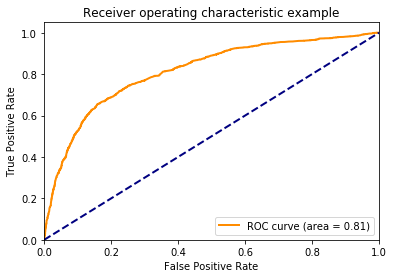

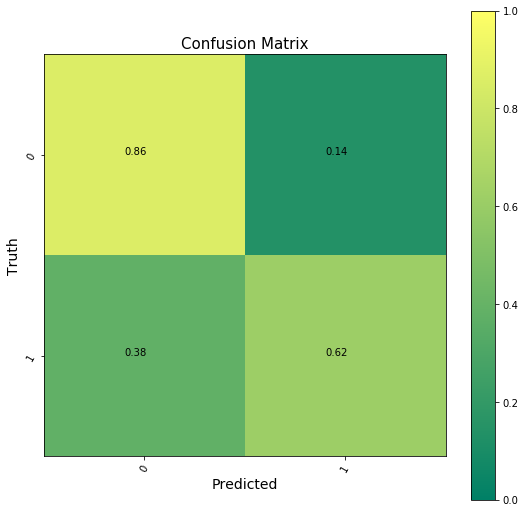

,serial,split,true_y,pred_y
0,567403,Validation,0,0.792220
1,573854,Validation,0,0.119861
2,577824,Validation,0,0.485571
3,593504,Validation,0,0.181170
4,598961,Validation,1,0.336047
5,609041,Validation,1,0.853749
6,609101,Validation,0,0.222492
7,611233,Validation,0,0.125600
8,612293,Validation,0,0.116665
9,617451,Validation,0,0.073494


In [32]:
# Model testing
val_lstm(sample_df, model_lstm.model, full_array_x, sample_df['y'], batch_size = 50, cutoff = 0.40,result_csv_save_name='lstm_result.csv')